## Google - Isolated Sign Language Recognition
### Team Members: Abdou Alrahman El-Ghazali
### Final Rank: [777](https://www.kaggle.com/competitions/asl-signs/leaderboard?search=abdoue)

# Table of Contents
- Introduction
- Packages
- Global Settings
- Helper Functions
- Custom Classes
- First Look at Data
    - Sign Frequency
    - Testing Landmark Consistency
    - Testing Maximum Timesteps
    - Average Frames Per Sign
    - Reducing Landmarks
- Testing Layers
    - Loading Example Parquet
    - Filtering Bad Frames
    - Normalizing and Centering
    - Standardizing Frame Count
    - Augmentation Testing
    - Dominant Hand Standardization (LR Standardization)
- Create TFRecords
- Loading Data
- Model
- Analysis
- Convert to TFLite



# Introduction

The goal of [this competition](https://www.kaggle.com/competitions/asl-signs) was to classify sign language footage for a phone application. The data consists of video footage, that has been processed into landmark features using the [MediaPipe Holistic Solution](https://github.com/google/mediapipe/blob/master/docs/solutions/holistic.md). We recieve frames containing (x, y, z) coordinates of landmark features that we then use to predict what word is being signed. Our solution must be fast, small, and run on TFLite.

Although the provided data was standardized rather well using the MediaPipe Holistic Solution, it still offered several difficulties. For starters, the data was collected from a marginal group of people which made it difficult for our model to generalize well against the hidden test set. In the future, it would be wise to collect more data using a much larger group of contributors to better capture nuanced differences in signing.

Missing frames and missing features were common - we solved this problem using a combination of filtering and masking. These model layers were self-contained, and activated during training as well as inference. In the future, it may be wiser to preprocess our training data with these layers so as to speed up training times.

Non-uniform frames were a major problem. While the data had consistent features, it did not have consistent frame counts. In fact the variation was rather large, with the average frames being somewhere in the 40 frame mark while the maximum observed was 536 frames. Many of the other competitors opted to use a subset of the frames in order to standardize them, some used `RaggedTensor`, this solution uses `TFRecords` built in function `bucket_by_sequence_length()` which behaves similarly to a `RaggedTensor` but has no compatibility issues with TFLite.

TFLite comaptibility was consistently an issue while building this solution. Because it is a lightweight version of TensorFlow, it doesn't offer all of the same functions and features. For example, we had to build our own inverse cosine function using Taylor series expansion since TFLite doesn't natively support the `tf.acos()` function. We also ran into issues while using the `MultiHeadAttention` layer and instead opted to build our own. For the majority of this project, TFLite was the biggest restriction.

### What didn't work:
1. GRU, LSTM architecture performed noticeably worse than a transformer
2. GRU, LSTM self-attention performed worse than Dense self-attention encoder
3. Removing bad frames helped the model train better, but performed worse during inference - masking worked better
4. Several augmentation methods either didn't or barely improved training or inference:
    - Flip augmentation (i.e. left to right and vice versa)
    - Translation
    - Scaling/warping
    - Random frame dropping

### What worked:
1. Flattening the 3 feature channels (x, y, z) into a time-distributed single Dense layer embedding
2. Trainable positional encoding inspired by BERT
3. Multiple, smaller self-attention heads rather than a single head
4. Left/right dominant hand selection using frame activity
5. Per-feature normalization
6. Simple Dense decoder using softmax

### Future work:
1. More data with a larger participant distribution
2. Better data preprocessing to reduce noise and remove unnecessary frames 
    - Central cropping
    - Relevant frame index detection
3. Better handling of the time element (the current solution does a `GlobalAveragePooling` of the transformer output)

### Reduced Experiments Log:

I ran an experiment where I only fed face, hands, pose at a time and found that the majority of learning comes from the hands. About 1/10 ratio of face to hands, or pose to hands in terms of initial learning speed. Our model needs to reflect this.

I ran an experiment where I tested the effect of padding (with mask) on learning and found that heavy padding trains faster. However, I suspect that the model may be fitting to noise. After further experimentation, I found that some words are similar but have different average frame counts. Using `bucket_by_sequence_length()` is likely restricting certain words from training together. It is better to use auto-padding where all words are in the same bucket, and are padded to the largest sequence. This takes longer, but provides better results.

I ran an experiment with feature engineering. It was clear that some signs are consistently being confused for others. Angle vectors improve the model's ability to distinguish between different signs that are similar in nature. For example, **bed** and **grass** are signed as an open palm near the face - the main difference between the signs is that in **grass** the *palm is facing upwards*, and in **bed** the *palm is facing the cheek*. [More on similar signs.](https://www.signingsavvy.com/article/173/Signs+That+Are+Close...+But+Not+the+Same+-+Set+1)

The model seems to find difficulty in distinguishing E from S. Both of these signs look like a closed fist, the main difference is thumb placement. Reducing Translational augmentation fixed this issue.

The model seems to find difficulty in distinguishing lips from mouth. Both of these signs - or more accurately some of the variations used to sign them - seem almost identical. No solution was found.

## Competition Workflow

![CompetitionWorkflow](CompetitionWorkflow.png)

# Packages

We use Pydot to handle parquet files. Pandas, Numpy, and TensorFlow do the rest.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import pydot

from matplotlib import pyplot as plt
from IPython.display import clear_output
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.experimental.numpy import absolute

# Global Settings

A good way to track model history.

In [2]:
FOLDER_PATH = 'D://MachineLearning/Google - ISL Recognition/asl-signs/'
SEED = 7
ROWS_PER_FRAME = 543  # Number of landmarks per frame (constant)
TEST_LANDMARKS = False # Whether to test the consistency of landmark indices in our parquet dataset
TEST_TIMESTEPS = False # Whether to test the maximum number of timesteps in our dataset
TEST_FRAMES_PER_SIGN = False # Whether to test the average frames per sign
CREATE_TFRECORD = False # Whether to run the script that converts our parquets into a TFRecord
TFRECORD_PATH_TRAIN = 'D://MachineLearning/Google - ISL Recognition/datatrain.tfrecord'
TFRECORD_PATH_TEST = 'D://MachineLearning/Google - ISL Recognition/datatest.tfrecord'
MAX_TIMESTEPS = 536
BATCH_SIZE = 32
CONCAT_DATASET = False # For the submission run, we set this True
VAL_SIZE = 7000 # Size of validation set (test set will be the same size)
DESIRED_FRAMES = 40 # About the average number of frames (inspired by: https://www.kaggle.com/code/markwijkhuizen/gislr-tf-data-processing-transformer-training#Percentage-of-Frames-Filled)

# Train and save
TRAIN = True
MODEL_PATH_TRAIN = 'isldetection135.h5'

# Use weights of old model (must match layers)
SET_WEIGHTS = False
MODEL_PATH_WEIGHTS = 'isldetection130.h5'

# Convert and save
CONVERT = True
OPTIMIZE = True
MODEL_PATH = 'model.tflite'

# Set TensorFlow seed
tf.random.set_seed(SEED) # Seeding the model

# Load metadata
csv = pd.read_csv(os.path.join(FOLDER_PATH, 'train.csv'), index_col='sequence_id')

# Loading sign dictionary
signs = pd.read_json(os.path.join(FOLDER_PATH, 'sign_to_prediction_index_map.json'), typ='series')

# Helper Functions

These are some of the functions used throughout this notebook. The more complex functions are not listed here and can be found where they are used.

In [3]:
# GISLR provided function
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Three Point Angle
def three_point_angle(hand, a, b, c, use_origin=False):
    # This function uses three points to get the angle between points A and C, using point B as origin
    # I.e. it is the angle between vectors BA and BC
    # Setting use_origin to True returns the angle between vector BA and the origin 0
    angle_a = tf.gather(hand, [a], axis=-2)
    angle_b = tf.gather(hand, [b], axis=-2)
    angle_c = tf.gather(hand, [c], axis=-2)
    if use_origin:
        # Turn angle3 into a ones vector for consistency in direction (zero vector doesn't really have direction)
        angle_c = tf.ones_like(angle_c)

    # Find the angle using our custom angle function
    three_point_angle = angle(angle_a - angle_b, 
                         angle_c - angle_b)
    return three_point_angle

# Magnitude of tensor
def magnitude(tensor):
    # magnitude = sqrt(x^2 + y^2 + z^2) for a 3D tensor
    x_squared = tf.square(tensor[..., 0:1])
    y_squared = tf.square(tensor[..., 1:2])
    z_squared = tf.square(tensor[..., 2:3])
    tensor = tf.sqrt(tf.add_n([x_squared, y_squared, z_squared]))
    return tensor

# Inverse Cosine
def acos(tensor):
    # Here we perform a Taylor series expansion using the first few terms because TFLite doesn't support native acos
    # We chose the first three terms because it delivers enough precision -> 
    # i.e. two terms gives us about 4 sig figs, three terms gives us about 5 sig figs which is about 0.0005 degrees
    # That level of precision is far too great for a human eye to detect - therefore we can assume signing isn't that precise
    # In fact, the first term alone might be more than enough
    pi = 3.141592653589793238462643383279502884197
    asin = (tensor + tf.math.pow(tensor, 3)/5 + 3*tf.math.pow(tensor, 5)/40)
    acos = pi / 2 - asin
    return acos

# Angle between two tensors
def angle(tensor1, tensor2):
    # Dot product
    tensordot = tf.reduce_sum(tf.multiply(tensor1, tensor2), axis=-1, keepdims=True)
    
    # Magnitude product
    tensormag = tf.multiply(magnitude(tensor1), magnitude(tensor2))
    
    # Remove zero
    tensormag = tf.where(tf.math.equal(tensormag, 0), tf.ones_like(tensormag), tensormag)
    
    # Divide by magnitude to create a unit vector which retains direction
    tensor = tf.divide(tensordot, tensormag)
    
#     # Inverse Cosine (TFLite doesn't support native acos operation)
# #     tensor = tf.acos(tensor)
#     tensor = acos(tensor)
    
#     # Remove zero
#     tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
    
    # Repeat for compatibility with channel shape
    tensor = tf.repeat(tensor, 3, axis=-1)
    
    return tensor

# Normalized direction of a tensor
def direction(tensor1, tensor2):
    # This function provides the direction between two tensors as a unit vector
    distance = tensor2 - tensor1
    tensormag = magnitude(distance)
    
    # Check for zeros before division
    tensormag = tf.where(tf.math.equal(tensormag, 0), tf.ones_like(tensormag), tensormag)
    
    return tf.divide(distance, tensormag)

def progressBar(count_value, total, suffix=''):
    # Simple progress bar as a function of i and total_i
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('Processing [%s] %s%s %s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()
    
# Create moving average for timeseries tensor
# Inspiration: https://www.kaggle.com/code/dilipkumar2k6/tensorflow-timeseries-moving-average
def tensor_moving_average(t, window_size, axis):
    # Repeat timesteps in case window_size is greater than the available timesteps (error prevention)
    repeats = window_size // tf.shape(t)[axis] + 1 # This repeats vector will always be 1 if window_size is < timesteps
    t = tf.repeat(t, repeats, axis=axis)
    timesteps = tf.shape(t)[axis]
    
    # Moving average over a given window size
    cumsum = tf.cumsum(t, axis=axis)
    uppersum = tf.gather(cumsum, tf.range(window_size, timesteps), axis=axis)
    lowersum = tf.gather(cumsum, tf.range(timesteps - window_size), axis=axis)
    ma = (uppersum - lowersum) / window_size
    return ma

def split_tensor(tensor):
    # Splits up a tensor into the 4 landmark feature categories
    face = tensor[..., 0:468, :]
    lhand = tensor[..., 468:489, :]
    pose = tensor[..., 489:522, :]
    rhand = tensor[..., 522:, :]
    
    return [face, lhand, pose, rhand]

def reshape_tensor(face, lhand, pose, rhand, group=True, batch=False):
    # This function reshapes the channels axis by flattening or by un-flattening into the features axis
    # Input shape: (..., features, channels) or (..., features*channels)
    if group:
        # Group by reshaping (faster than concat)
        if batch:
            def reshape(t):
                t = layers.Reshape((-1, 3*t.shape[-2]))(t)
                return t
        else:
            def reshape(t):
                t = tf.reshape(t, (-1, 3*tf.shape(t)[-2]))
                return t
    
    else:
        # Ungroup by reshaping
        if batch:
            def reshape(t):
                t = layers.Reshape((-1, int(t.shape[-1]/3), 3))(t)
                return t
        else:
            def reshape(t):
                t = tf.reshape(t, (-1, int(t.shape[-1]/3), 3))
                return t    
            
    face = reshape(face)
    lhand = reshape(lhand)
    pose = reshape(pose)
    rhand = reshape(rhand)
    
    return [face, lhand, pose, rhand]

def plot_landmarks(df, feature, scale=1):
    # This function plots landmarks with their correct edges using the edges dictionary (found below)
    # Select feature
    df = df[df['type'] == feature]
    
    if feature != 'face':
        # Create plot
        plt.scatter(scale*df['x'], -1*df['y'])
        
        # Add index labels to plot
        for i, point in df.iterrows():
            plt.text(scale*point['x'], -1*point['y'], str(point['landmark_index']))
            
        for edge in edges[feature]:
            temp1 = df[df['landmark_index'] == edge[0]]
            temp2 = df[df['landmark_index'] == edge[1]]
            temp = pd.concat([temp1, temp2])
            plt.plot(scale*temp['x'], -1*temp['y'], color='purple')
    else:
        # Create plot
        plt.scatter(scale*df['x'], -1*df['y'])
            
    # Args
    plt.axis('off')
    
def plot_landmarks_and_invert(df, feature):
    # This function compares the original and inverted landmark plots
    plt.subplot(1, 2, 1)
    plot_landmarks(df, feature, scale= 1)
    plt.title(feature)
    
    plt.subplot(1, 2, 2)
    plot_landmarks(df, feature, scale= -1)
    plt.title(feature + ' inverted')
    
    # Show plot
    plt.show()
    
def plot_landmarks_tensor(tensor, feature, scale=1, frame=0, axoff=False, index=True, show_origin=False):
    # This function plots landmark tensors (rather than dataframes)
    # Select feature
    df = pd.DataFrame()
    df['x'] = tensor[frame, :, 0]
    df['y'] = tensor[frame, :, 1]
    df['landmark_index'] = list(range(tensor.shape[1]))
    
    if feature != 'face':
        # Create plot
        plt.scatter(scale*df['x'], -1*df['y'])
        
        if index:
            # Add index labels to plot
            for i, point in df.iterrows():
                plt.text(scale*point['x'], -1*point['y'], str(point['landmark_index']))
            
        for edge in edges[feature]:
            temp1 = df[df['landmark_index'] == edge[0]]
            temp2 = df[df['landmark_index'] == edge[1]]
            temp = pd.concat([temp1, temp2])
            plt.plot(scale*temp['x'], -1*temp['y'], color='purple')
    else:
        # Create plot
        plt.scatter(scale*df['x'], -1*df['y'], s=5)
            
    # Args
    if axoff:
        plt.axis('off')
        
    if show_origin:
        plt.axhline(0, color='r')
        plt.axvline(0, color='r')

def plot_all_tensor(tensor, frame=0):
    # This function displays all 4 landmark categories
    f, l, p, r = split_tensor(tensor)
    fig = plt.figure()
    
    plt.subplot(2, 2, 1)
    plot_landmarks_tensor(f, 'face', frame=frame)
    plt.title('face')
    plt.subplot(2, 2, 2)
    plot_landmarks_tensor(l, 'left_hand', frame=frame)
    plt.title('left_hand')
    plt.subplot(2, 2, 3)
    plot_landmarks_tensor(p, 'pose', frame=frame)
    plt.title('pose')
    plt.subplot(2, 2, 4)
    plot_landmarks_tensor(r, 'right_hand', frame=frame)
    plt.title('right_hand')
    
    fig.tight_layout()
    plt.show()

def plot_two_tensors(tensor1, tensor2, frame=0, label='filtered', show_origin=False):
    # This function displays all 4 landmark categories for two different tensors
    # Useful in comparing various tensor manipulation functions
    f1, l1, p1, r1 = split_tensor(tensor1)
    f2, l2, p2, r2 = split_tensor(tensor2)
    axoff = False
    index = False
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(2, 4, 1)
    plot_landmarks_tensor(f1, 'face', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('face')
    plt.subplot(2, 4, 2)
    plot_landmarks_tensor(l1, 'left_hand', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('left_hand')
    plt.subplot(2, 4, 3)
    plot_landmarks_tensor(p1, 'pose', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('pose')
    plt.subplot(2, 4, 4)
    plot_landmarks_tensor(r1, 'right_hand', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('right_hand')
    
    plt.subplot(2, 4, 5)
    plot_landmarks_tensor(f2, 'face', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('face ' + label)
    plt.subplot(2, 4, 6)
    plot_landmarks_tensor(l2, 'left_hand', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('left_hand ' + label)
    plt.subplot(2, 4, 7)
    plot_landmarks_tensor(p2, 'pose', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('pose ' + label)
    plt.subplot(2, 4, 8)
    plot_landmarks_tensor(r2, 'right_hand', frame=frame, axoff=axoff, index=index, show_origin=show_origin)
    plt.title('right_hand ' + label)
    
    fig.tight_layout()
    plt.show()
    
def invert_function(t):
    # This function inverts/mirrors a tensor alongside the x axis
    # Variables
    x = t[..., :1] # x axis
    yz = t[..., 1:] # y and z axes
    t_max = tf.reduce_max(x) # max used to adjust horizontal flip
    print(t_max)
    # Recombine flipped x with y and z
    t = tf.concat([
        tf.subtract(t_max, x), # flip
        yz
    ], axis=-1) 

    return t

def pull_pose(pose):      
    # This function pulls and normalizes the left arm, right arm, and face from the pose landmark category
    def center(tensor, coordinate):
        # Tensor of shape (timesteps, rows, channels)
        # Coordinate of shape (None, 1, 3)
        return tf.subtract(tensor, coordinate)
    
    def find_center(tensor, features):
        # Find origin point
        t_center = tf.gather(tensor, features, axis=-2)
        
        # Find the average center of all tensors
        t_center = tf.reduce_sum(t_center, axis=-2, keepdims=True)
        
        # Center
        t_center = tf.divide(t_center, len(features))

        return t_center

    def normalize(tensor, features):
        # Normalize from -1 to 1
        # Find max value from desired features
        t_max = tf.zeros_like(tensor)
        for f in features:
            ft = tf.gather(tensor, [f], axis=-2)
            t_max = tf.maximum(t_max, tf.abs(ft))
        
        # Make sure t_max is greater than 0
        t_max = tf.where(tf.greater(t_max, 0), t_max, tf.ones_like(t_max))
        
        # Divide by tensor max
        tensor = tf.divide(tensor, t_max)
        
        return tensor
    
    # Landmark features to be used for centering
    left_features = [0, 1] # [11, 13]
    right_features = [0, 1] # [12, 14]
    pface_features = [0, 1, 4] # [0, 1, 4]
    
    larm = tf.gather(pose, left_arm, axis=-2)
    rarm = tf.gather(pose, right_arm, axis=-2)
    pface = tf.gather(pose, pose_face, axis=-2)
    
    # Find center point
    larm_center = larm[..., 0:1, :]
    rarm_center = rarm[..., 0:1, :]
    pface_center = pface[..., 0:1, :]

    # Center features
    larm = center(larm, larm_center)
    rarm = center(rarm, rarm_center)
    pface = center(pface, pface_center)
    
    # Normalization
    larm = normalize(larm, left_features)
    rarm = normalize(rarm, right_features)
    pface = normalize(pface, pface_features)
    
    return [larm, rarm, pface]

# Custom Classes

These are some of the classes used in this notebook. The first is a callback to plot training curves while training, the rest are custom layers used to augment our data.

In [4]:
# Live plotting for training metrics (source: https://www.kaggle.com/code/tasnimnishatislam/check-data)

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate(tf.cast(self.model.optimizer.iterations, tf.float32))
        print(f"Learning rate for epoch {epoch+1}: {lr:.5f}")

In [5]:
# In ASL, the right hand and left hand can be interchanged as the dominant signing hand.
# Because of this, we can augment our data by inverting the landmarks appropriately.

class RandomLR(tf.keras.layers.Layer):
    def __init__(self, rate=0.5):
        super(RandomLR, self).__init__()
        self.rate = 1 - rate
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "rate": self.rate,
        })
        return config
    
    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        # Recompute mask because of flip        
        return tf.reduce_any(tf.not_equal(inputs, 0.), axis=-1) # Taken from Masking layer source
    
    def call(self, inputs, training=None):
        if training:
            # Generate a random value to determine whether to apply the flip transform
            flip_val = tf.random.uniform(shape=[], maxval=1.0)
            # Apply the flip transform if the random value is less than 0.5 or input rate
            
            if flip_val > self.rate:
                # Inputs in appropriate order:
                # face = inputs[0]
                # lhand = inputs[1]
                # pose = inputs[2]
                # rhand = inputs[3]
                
                def invert_function(t):
                    # Variables
                    x = t[..., :1] # x axis
                    yz = t[..., 1:] # y and z axes
#                     t_max = tf.reduce_max(x) # max used to adjust horizontal flip
                    
                    # Recombine flipped x with y and z
                    t = tf.concat([
#                         tf.add(-1 * x, t_max), # flip and recenter
                        tf.multiply(x, -1), # flip
                        yz
                    ], axis=-1) 
                    
                    return t
                
                # Invert face, lhand, pose, and rhand horizontally
                # Switch lhand with rhand
                face = invert_function(inputs[0])
                lhand = invert_function(inputs[3])
                pose = invert_function(inputs[2])
                rhand = invert_function(inputs[1])

                return [face, lhand, pose, rhand]
            else:       
                return inputs
        else:       
            return inputs

In [6]:
# We can also augment by translating our data with this RandomShift layer

class RandomShift(tf.keras.layers.Layer):
    def __init__(self, rate=0.5, factor=0):
        super(RandomShift, self).__init__()
        self.rate = 1 - rate
        self.factor = factor
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "rate": self.rate,
            "factor": self.factor,
        })
        return config
    
    def compute_mask(self, inputs, mask=None):
        return mask
    
    def call(self, inputs, training=None):
        if training:
            # Generate a random value to determine whether to apply the flip transform
            flip_val = tf.random.uniform(shape=[], maxval=1.0)
            
            # Apply the shift transform if the random value is less than 0.5 or input rate
            if flip_val > self.rate:
                # Inputs in appropriate order:
                # face = inputs[0]
                # lhand = inputs[1]
                # pose = inputs[2]
                # rhand = inputs[3]
                
                def adjust_function(t):
                    # Translation factor
                    adjustment = tf.random.uniform(shape=tf.shape(t), minval=-self.factor, maxval=self.factor)
                    
                    # Never shift zeros
                    zeros = tf.equal(tf.reduce_sum(t, axis=(-2,-1), keepdims=True), 0)
                    adjustment = tf.where(zeros, tf.zeros_like(adjustment), adjustment)
                    
                    # Translate
                    t = tf.add(t, adjustment)
                    
                    return t
                
                # Shift tensors by a random amount between -factor and +factor
#                 face = adjust_function(inputs[0])
                face = inputs[0]
                lhand = adjust_function(inputs[1])
                pose = adjust_function(inputs[2])
                rhand = adjust_function(inputs[3])

                return [face, lhand, pose, rhand]
            else:       
                return inputs
        else:       
            return inputs

In [7]:
# We can also augment by scaling our data with this RandomScale layer

class RandomScale(tf.keras.layers.Layer):
    def __init__(self, rate=0.5, factor=0):
        super(RandomScale, self).__init__()
        self.rate = 1 - rate
        self.factor = factor
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "rate": self.rate,
            "factor": self.factor,
        })
        return config
    
    def compute_mask(self, inputs, mask=None):
        return mask
    
    def call(self, inputs, training=None):
        if training:
            # Generate a random value to determine whether to apply the flip transform
            flip_val = tf.random.uniform(shape=[], maxval=1.0)
            
            # Apply the shift transform if the random value is less than 0.5 or input rate
            if flip_val > self.rate:
                # Inputs in appropriate order:
                # face = inputs[0]
                # lhand = inputs[1]
                # pose = inputs[2]
                # rhand = inputs[3]
                
                def adjust_function(t):
                    # Scale factor randomly chosen for each coordinate
                    adjustmentx = tf.random.uniform(shape=[], minval=-self.factor, maxval=self.factor) + 1
                    adjustmenty = tf.random.uniform(shape=[], minval=-self.factor, maxval=self.factor) + 1
                    adjustmentz = tf.random.uniform(shape=[], minval=-self.factor, maxval=self.factor) + 1
                    
                    # Variables
                    x = t[..., :1] # x axis
                    y = t[..., 1:2] # y axis
                    z = t[..., 2:3] # z axis
                    
                    # Recombine scaled x, y, and z
                    t = tf.concat([
                        tf.multiply(x, adjustmentx),
                        tf.multiply(y, adjustmenty),
                        tf.multiply(z, adjustmentz),
                    ], axis=-1) 
                    
                    return t
                
                # Scale tensors by a random amount between -factor and +factor
                face = adjust_function(inputs[0])
                lhand = adjust_function(inputs[1])
                pose = adjust_function(inputs[2])
                rhand = adjust_function(inputs[3])

                return [face, lhand, pose, rhand]
            else:       
                return inputs
        else:       
            return inputs

In [8]:
# We can also augment by randomly zeroing out features to mimic, for example, a hand leaving the frame

class RandomZero(tf.keras.layers.Layer):
    def __init__(self, rate=0.5):
        super(RandomZero, self).__init__()
        self.rate = 1 - rate
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "rate": self.rate,
        })
        return config
    
    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        # Recompute mask because of dropout        
        return tf.reduce_any(tf.not_equal(inputs, 0.), axis=-1) # Taken from Masking layer source
    
    def call(self, inputs, training=None):
        if training:
            # Generate a random value to determine whether to apply the flip transform
            flip_val = tf.random.uniform(shape=[], maxval=1.0)
            
            # Apply the zero transform if the random value is less than 0.5 or input rate
            if flip_val > self.rate:
                # Input is a tensor representing one of the subcategories (face, lhand, pose, rhand)
                # Shape is (batch, frames, rows, channels)
                
                def adjust_function(t):
                    # Index randomly chosen
                    frame = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(t)[-3], dtype=tf.int32)
                    
                    # Create zero frame
                    zeros = tf.zeros_like(t[..., frame:frame + 1, :, :])
                    
                    # Collect remainder
                    t1 = t[..., :frame, :, :]
                    t2 = t[..., frame + 1:, :, :]
                    
                    # Combine
                    t = tf.concat([t1, zeros, t2], axis=-3)
                    
                    return t
                
                # Activate function
                inputs = adjust_function(inputs)

                return inputs
            else:       
                return inputs
        else:       
            return inputs

# First Look at Data

## Sign Frequency

We have a good distribution of data for each sign, so it's less likely that we have to worry about data imbalances. However, some signs may be similar, or there may be other factors that make them more difficult to detect than others.

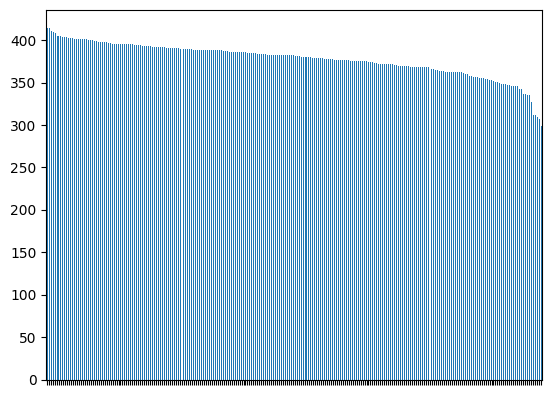

In [9]:
ax = csv['sign'].value_counts().sort_values(ascending=False).plot(kind='bar')
ax.set_xticklabels('')
plt.show()

In [10]:
csv['sign'].value_counts().sort_values(ascending=False).tail()

dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, dtype: int64

Using this information we can derive weights for each class in a rather simple manner:

In [11]:
# Class weights
(csv['sign'].value_counts().max() / csv['sign'].value_counts()).sort_index()

TV           1.077922
after        1.195965
airplane     1.055980
all          1.075130
alligator    1.064103
               ...   
yesterday    1.042714
yourself     1.077922
yucky        1.094987
zebra        1.106667
zipper       1.387960
Name: sign, Length: 250, dtype: float64

Crucially, the entire dataset consists of only 21 participants signing over 90,000 times. We have to be careful how we create our test set because of this. A good test set will contain participants that are not included in either the training or validation sets. That way we can better gauge how well our model generalizes, and avoid leaking participant specific data to our model during training. For example, if one participant signs "TV" 20 times, we can't use that data in both training and test sets.

We will select one participant for our test set: `participant_id = 61333`

In [12]:
csv['participant_id'].unique()

array([26734, 28656, 16069, 25571, 62590, 32319, 37055, 29302, 49445,
       36257, 22343, 27610, 61333, 53618, 34503, 18796,  4718, 55372,
        2044, 37779, 30680], dtype=int64)

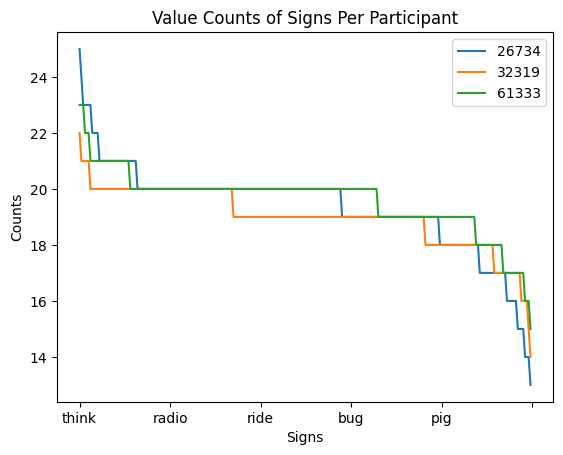

In [13]:
for participant in csv['participant_id'].unique():
    plotdf = csv[csv['participant_id'] == participant]['sign'].value_counts()
    if all(plotdf > 12):
        plotdf.plot(label=participant)

# set the title and axis labels
plt.title('Value Counts of Signs Per Participant')
plt.xlabel('Signs')
plt.ylabel('Counts')
plt.legend()

In [14]:
test_csv = csv[csv['participant_id'].isin([61333])]
test_csv

,path,participant_id,sign
sequence_id,,,
1000909322,train_landmark_files/61333/1000909322.parquet,61333,shirt
1001819372,train_landmark_files/61333/1001819372.parquet,61333,balloon
1002052130,train_landmark_files/61333/1002052130.parquet,61333,TV
1003093029,train_landmark_files/61333/1003093029.parquet,61333,pizza
1005476876,train_landmark_files/61333/1005476876.parquet,61333,down
...,...,...,...
995793615,train_landmark_files/61333/995793615.parquet,61333,will
996662345,train_landmark_files/61333/996662345.parquet,61333,nap
998717063,train_landmark_files/61333/998717063.parquet,61333,pizza


In [15]:
train_csv = csv[~csv['participant_id'].isin([61333])]
train_csv

,path,participant_id,sign
sequence_id,,,
1000035562,train_landmark_files/26734/1000035562.parquet,26734,blow
1000106739,train_landmark_files/28656/1000106739.parquet,28656,wait
100015657,train_landmark_files/16069/100015657.parquet,16069,cloud
1000210073,train_landmark_files/25571/1000210073.parquet,25571,bird
1000240708,train_landmark_files/62590/1000240708.parquet,62590,owie
...,...,...,...
999786174,train_landmark_files/53618/999786174.parquet,53618,white
999799849,train_landmark_files/26734/999799849.parquet,26734,have
999833418,train_landmark_files/25571/999833418.parquet,25571,flower


### Example Parquet 1:

The first example has 7 frames, and 4 landmark types. The indices for the beginning of these landmark types are `[0, 468, 489, 522]`.

In [16]:
example_path = os.path.join(FOLDER_PATH, 'train_landmark_files', '2044', '635217.parquet')
load_relevant_data_subset(example_path).shape

(7, 543, 3)

In [17]:
example_data = pd.read_parquet(example_path)
example_data.drop_duplicates('type', keep='first')

,frame,row_id,type,landmark_index,x,y,z
0,22,22-face-0,face,0,0.438251,0.449453,-4.782642e-02
468,22,22-left_hand-0,left_hand,0,NaN,NaN,NaN
489,22,22-pose-0,pose,0,0.422691,0.389004,-1.030262e+00
522,22,22-right_hand-0,right_hand,0,0.094635,0.453895,-4.997149e-07


### Example Parquet 2:

The second example has 22 frames, but consistent indices for landmark types. This is really good news! All the data produced by `MediaPipe Holistic Landmarks` falls in line within this landmark framework, preprocessing will be much easier. We will still have to pad the missing frames, but that process is pretty simple and can be done with `TFRecords` and `bucket_by_sequence_length()`. 

It seems that missing features are filled with `NaN` values. We can take care of this issue by converting `NaN` to `0` and masking during model training.

In [18]:
example_path = os.path.join(FOLDER_PATH, 'train_landmark_files', '2044', '3127189.parquet')
load_relevant_data_subset(example_path).shape

(22, 543, 3)

In [19]:
example_data = pd.read_parquet(example_path)
example_data.drop_duplicates('type', keep='first')

,frame,row_id,type,landmark_index,x,y,z
0,21,21-face-0,face,0,0.479847,0.478954,-4.496872e-02
468,21,21-left_hand-0,left_hand,0,NaN,NaN,NaN
489,21,21-pose-0,pose,0,0.478415,0.429681,-1.562254e+00
522,21,21-right_hand-0,right_hand,0,0.169730,0.666531,-1.974327e-07


## Testing Landmark Consistency

Let's run a crude script to check whether our dataset has consistent landmark indices.

**Note: Surprisingly, it does! That makes our job a whole lot easier.**

In [20]:
# test if landmark indices are consistent across all parquets
if TEST_LANDMARKS:
    length = len(csv)
    example_index = example_data.drop_duplicates('type', keep='first').index

    for i, row in enumerate(csv.T):
        path = os.path.join(FOLDER_PATH, csv.loc[row].path)
        example_data = pd.read_parquet(path)
        if all(example_index != example_data.drop_duplicates('type', keep='first').index):
            print('\npath')
            print('Does not match.')
            break

        progressBar(i + 1, length)

## Testing Maximum Timesteps

Our data has inconsistent timesteps. One parquet may have 30 frames, another may have 300. Let's find out what the upper bound limit is so we can better decide on how to bucket our dataset later.

In [21]:
# test max number of timesteps across all parquets
if TEST_TIMESTEPS:
    length = len(csv)    
    max_timesteps = 0
    
    for i, row in enumerate(csv.T):
        path = os.path.join(FOLDER_PATH, csv.loc[row].path)
        example_data = pd.read_parquet(path)
        frame_arr = example_data['frame'].values
        timesteps = frame_arr[-1] - frame_arr[0] # Last minus first frame number for total frame length
        
        if timesteps > max_timesteps:
            max_timesteps = timesteps

        progressBar(i + 1, length)
        
    MAX_TIMESTEPS = max_timesteps

In [22]:
MAX_TIMESTEPS

536

## Average Frames Per Sign

It's possible to adjust the training weights using the average frames per sign. The logic behind this is that there is less training data for some signs based on the lower average frames per sign.

**Note: these weights weren't used in the final submission**

In [23]:
# test average number of timesteps (frames) per sign
if TEST_FRAMES_PER_SIGN:
    length = len(csv)    
    frame_count = np.zeros(250)
    frame_min = np.zeros(250) + MAX_TIMESTEPS
    frame_max = np.zeros(250)
    data_count = np.zeros(250)
    
    for i, row in enumerate(csv.T):
        # Load data
        path = os.path.join(FOLDER_PATH, csv.loc[row].path)
        example_data = pd.read_parquet(path)
        
        # Number of timesteps
        frame_arr = example_data['frame'].values
        timesteps = frame_arr[-1] - frame_arr[0] # Last minus first frame number for total frame length
        
        # Sign
        frame_sign = signs[csv.loc[row].sign]
        
        # Append
        frame_count[frame_sign] += timesteps
        frame_min[frame_sign] = (timesteps if timesteps < frame_min[frame_sign] else frame_min[frame_sign])
        frame_max[frame_sign] = (timesteps if timesteps > frame_max[frame_sign] else frame_max[frame_sign])
        data_count[frame_sign] += 1

        progressBar(i + 1, length)

In [24]:
if TEST_FRAMES_PER_SIGN:
    frames_df = pd.DataFrame({
        'sign': signs.index,
        'frame_count': frame_count,
        'frame_min': frame_min,
        'frame_max': frame_max,
        'data_count': data_count,
    })
    
    frames_df.to_csv('frames_df.csv', index=False)
else:
    frames_df = pd.read_csv('frames_df.csv')

In [25]:
frames_df

,sign,frame_count,frame_min,frame_max,data_count
0,TV,13812.0,2.0,283.0,385.0
1,after,10199.0,1.0,247.0,347.0
2,airplane,16881.0,1.0,247.0,393.0
3,all,13704.0,3.0,247.0,386.0
4,alligator,17631.0,4.0,413.0,390.0
...,...,...,...,...,...
245,yesterday,15307.0,4.0,264.0,398.0
246,yourself,13114.0,2.0,218.0,385.0
247,yucky,13811.0,1.0,258.0,379.0
248,zebra,14024.0,1.0,299.0,375.0


<AxesSubplot: >

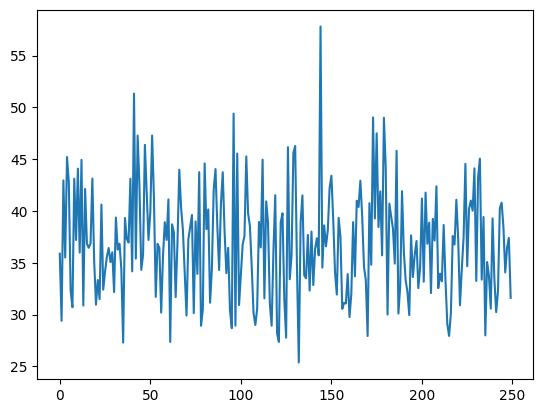

In [26]:
frames_df['frame_average'] = frames_df['frame_count'] / frames_df['data_count']
frames_df['frame_average'].plot()

## Reducing Landmarks

Since the model will be running on mobile, we can reduce some of the landmark features to the bear minimum. The face landmark category has a significant amount of unnecessary data that we can simply trim to improve model speed.

Even though we use facial expressions to [express emotions and other linguistic information](https://www.uib.no/en/hf/136874/complex-system-facial-expressions-sign-language), we have confirmed that the majority of learning for this data comes from the dominant hand. After that, using the entire face versus only the lips led to indistinguishable results. 

In [27]:
# These are only the plot edges used visualize the data
edges = { # Source: https://www.kaggle.com/code/tatamikenn/islr-eda-let-s-get-landmarks-animated
    'left_hand': [
        (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7), (7, 8), (5, 9), (9, 10),
        (10, 11), (11, 12), (9, 13), (13, 14), (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20), 
    ],
    'right_hand': [
        (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7), (7, 8), (5, 9), (9, 10), (10, 11),
        (11, 12), (9, 13), (13, 14), (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20), 
    ],
    'pose': [
        (8, 6), (6, 5), (6, 4), (4, 0), (0, 1), (1, 2), (2, 3), (3, 7), (10, 9), (11, 12), (11, 13),
        (11, 23), (13, 15), (15, 21), (15, 17), (15, 19), (17, 19), (12, 14), (12, 24), (14, 16), (16, 22), 
        (16, 20), (16, 18), (18, 20), (23, 24), (24, 26), (26, 28), (28, 30), (28, 32), (30, 32), (23, 25), 
        (25, 27), (27, 29), (27, 31), (29, 31),
    ],
}

In [28]:
example_data = pd.read_parquet(example_path)
example_data = example_data[example_data['frame'] == 21]

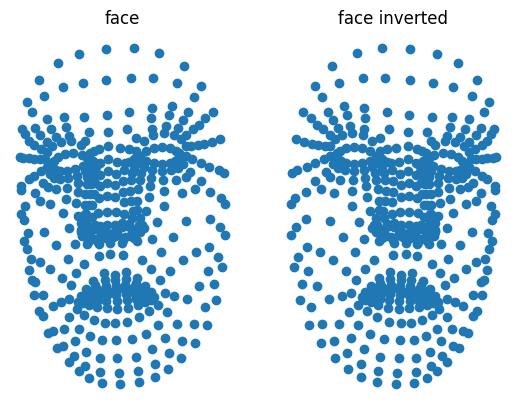

In [29]:
# Face
plot_landmarks_and_invert(example_data, 'face')

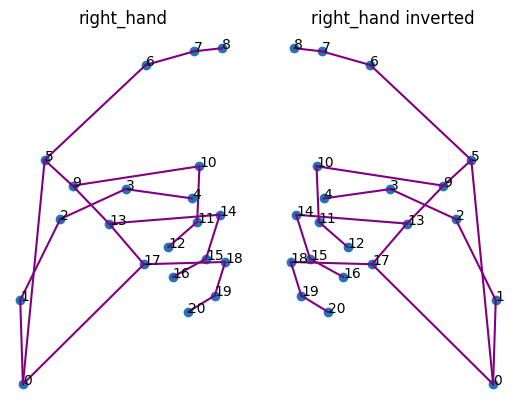

In [30]:
# Right Hand
# Note that the right hand inverted is basically just a left hand
plot_landmarks_and_invert(example_data, 'right_hand')

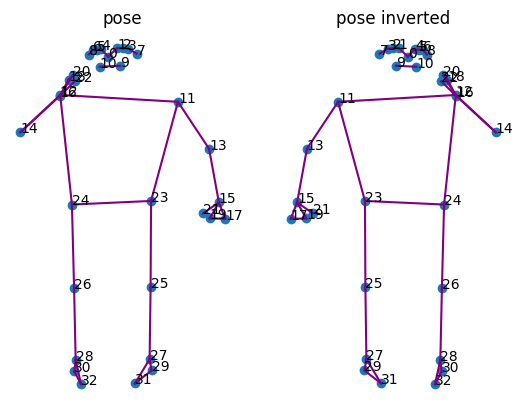

In [31]:
# Pose
plot_landmarks_and_invert(example_data, 'pose')

In [32]:
# reduced face (lips only)
lip_rows = [
    # Center
    61, 291, 0, 17,
    185, 40, 39, 37, 267, 269, 270, 409,
    146, 91, 181, 84, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
] # source: https://www.kaggle.com/datasets/hengck23/asl-demo

# reduced face (lips, eyes, eyebrows, and tip of nose)
face_rows = [
    # Center
    0, 1, 33, 263,
    # Lips (source: https://www.kaggle.com/datasets/hengck23/asl-demo)
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    # Eye 1
    7,246,161,160,159,158,157,173,133,155,154,153,145,144,163,
    # Eye 2
    362,398,384,385,386,387,388,466,249,390,373,374,380,381,382,
    # Eyebrow 1
    107,55,65,52,53,46,63,105,66,
    # Eyebrow 2
    336,285,295,282,283,276,293,334,296,
]

# eyes from face category
eye_rows = [
    # Eye 1
    7,246,161,160,159,158,157,173,133,155,154,153,145,144,163,
    # Eyebrow 1
    107,55,65,52,53,46,63,105,66,
]

# pose without legs (without 25-32)
pose_rows = [i for i in range(25)]

# pose subcategories
arm_l = [11, 13, 15, 17, 19, 21]
arm_r = [12, 14, 16, 18, 20, 22]
face_p = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

This is what our data looks like after it has been reduced!

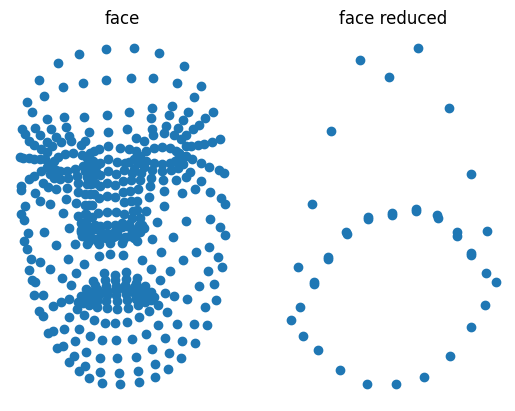

In [33]:
# Face
plt.subplot(1, 2, 1)
plot_landmarks(example_data, 'face')
plt.title('face')

plt.subplot(1, 2, 2)
plot_landmarks(example_data[example_data['landmark_index'].isin(lip_rows)], 'face')
plt.title('face reduced')

# Show plot
plt.show()

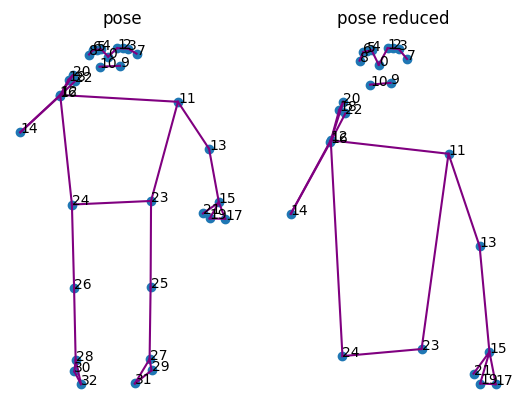

In [34]:
# Pose filtered
plt.subplot(1, 2, 1)
plot_landmarks(example_data, 'pose')
plt.title('pose')

plt.subplot(1, 2, 2)
plot_landmarks(example_data[example_data['landmark_index'].isin(pose_rows)], 'pose')
plt.title('pose reduced')

# Show plot
plt.show()

# Testing Layers

## Loading Example Parquet

In [40]:
frame = 0
example_path = os.path.join(FOLDER_PATH, 'train_landmark_files', '28656', '65482652.parquet')
test = pd.read_parquet(example_path)

# Creating right hand test
df = test[test['type'] == 'right_hand'][['frame', 'landmark_index', 'x', 'y', 'z']].set_index(['frame', 'landmark_index'], drop=True)
arr = df.values.reshape((len(df.index.levels[0]), len(df.index.levels[1]), -1))
testr = tf.constant(arr).numpy()

In [41]:
df_full = test[['frame', 'x', 'y', 'z']].set_index(['frame'], drop=True)
df_full.head()

,x,y,z
frame,,,
18,0.463268,0.532991,-0.048820
18,0.457094,0.490278,-0.069926
18,0.458712,0.504949,-0.041831
18,0.449889,0.461728,-0.043539
18,0.457404,0.479810,-0.072129


In [42]:
# Creating a tensor that includes all landmarks
arr_full = [df_full.loc[i + df_full.index.min()].to_numpy() for i in range(df_full.index.max() - df_full.index.min())]
test_full = tf.constant(arr_full)
test_full = tf.where(tf.math.is_nan(test_full), tf.zeros_like(test_full), test_full)
test_full.shape

TensorShape([34, 543, 3])

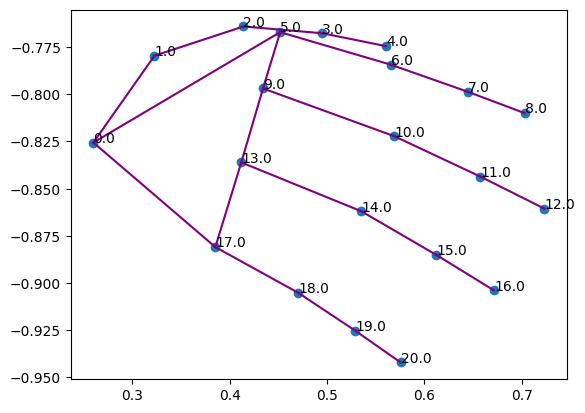

In [47]:
plot_landmarks_tensor(testr, 'right_hand')

## Filtering Bad Frames

This method removes, or zeros out bad frames. We define bad frames as:
- Frames that are missing (all nan or all zero)
- Frames where both hands are missing
- Frames where pose is missing
- Frames where face is missing

In [50]:
def filter_bad_frames(tensor, remove=False, batch=False):
    # Input of shape (batch, frames, rows, channels)
    face, lhand, pose, rhand = split_tensor(tensor)
    
    # Filter shape: (batch, frames, features)
    face, lhand, pose, rhand = reshape_tensor(face, lhand, pose, rhand, group=True, batch=batch) 
    
    # Find all zero features
    fzeros = tf.math.reduce_all(tf.equal(face, 0), axis=-1, keepdims=True)
    lzeros = tf.math.reduce_all(tf.equal(lhand, 0), axis=-1, keepdims=True)
    pzeros = tf.math.reduce_all(tf.equal(pose, 0), axis=-1, keepdims=True)
    rzeros = tf.math.reduce_all(tf.equal(rhand, 0), axis=-1, keepdims=True)

    # Combine
    both_nans = tf.logical_and(lzeros, rzeros)
    both_nans = tf.logical_or(both_nans, fzeros)
    both_nans = tf.logical_or(both_nans, pzeros)
    
    if remove:
        # Remove bad frames
        both_nans = tf.reduce_all(both_nans, axis=-1)
        all_bad = tf.reduce_all(both_nans, axis=-1, keepdims=True) # Are all frames bad?
        both_nans = tf.logical_not(both_nans)
        
        # If all frames are bad frames, remove mask
        all_bad = tf.repeat(all_bad, tf.shape(tensor)[-3], axis=-1) # Frame matching
        both_nans = tf.where(all_bad, tf.logical_not(both_nans), both_nans)
        
        # 
#         print(tensor.shape)
#         print(tf.where(both_nans[0]).shape)
        
        # Otherwise use mask to remove bad frames
        if batch:
            tensor, _ = tf.map_fn(lambda x: [tf.boolean_mask(x[0], x[1]), x[1]], [tensor, both_nans])
        else:
            tensor = tf.boolean_mask(tensor, both_nans, axis=0)
        
#         print(tensor.shape)
#         # Return original tensor where all frames are bad, otherwise return reduced tensor
#         tensor = tf.where(tf.reduce_all(both_nans, axis=-1), tensor, tf.boolean_mask(tensor, both_nans, axis=0))
    
    else:
        # Set all bad frames to zero
        both_nans = tf.reduce_all(both_nans, axis=-1, keepdims=True)
        both_nans = tf.expand_dims(both_nans, axis=-1)
        tensor = tf.where(both_nans, tf.zeros_like(tensor), tensor)
    
    return tensor  

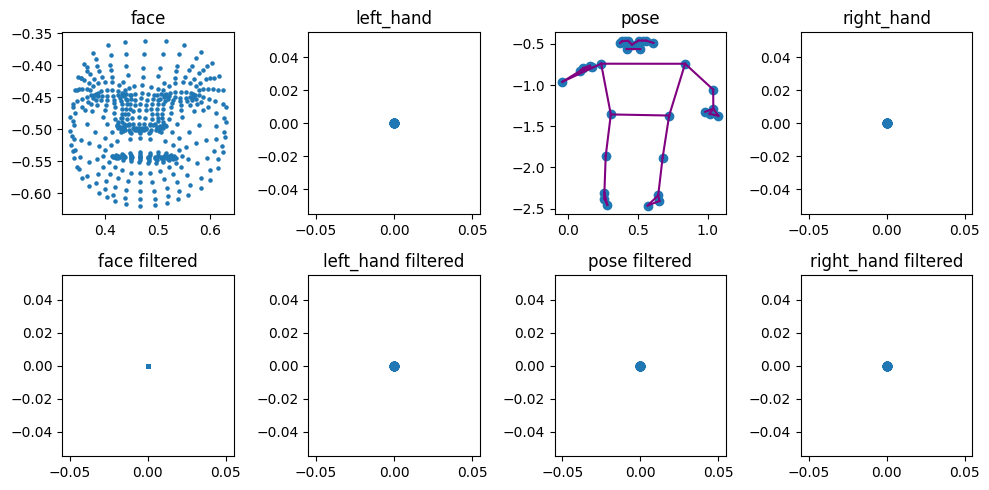

In [52]:
plot_two_tensors(test_full, filter_bad_frames(test_full, remove=False, batch=False), frame=17)

## Normalizing and Centering

This method scales all features seperately, and centers them to specific landmark points (shown in the function below). This was one of the most effective methods at improving model training.

In [46]:
def normalize_center(face, lhand, pose, rhand):        
    def center(tensor, coordinate):
        # Tensor of shape (None, None, 3)
        # Coordinate of shape (None, 1, 3)
        return tf.subtract(tensor, coordinate)
    
    def find_center(tensor, features):
        # Find origin point
        t_center = tf.gather(tensor, features, axis=-2)
        
        # Find the average center of all tensors
        t_center = tf.reduce_sum(t_center, axis=-2, keepdims=True)
        
        # Center
        t_center = tf.divide(t_center, len(features))

        return t_center

    def normalize(tensor, features):
        # Normalize from -1 to 1
        # Find max value from desired features
        t_max = tf.zeros_like(tensor)
        for f in features:
            ft = tf.gather(tensor, [f], axis=-2)
            t_max = tf.maximum(t_max, tf.abs(ft))
        
        # Make sure t_max is greater than 0
        t_max = tf.where(tf.greater(t_max, 0), t_max, tf.ones_like(t_max))
        
        # Divide by tensor max
        tensor = tf.divide(tensor, t_max)
        
        return tensor
    
    # Landmark features to be used for centering
#     face_features = [1, 2, 3] # These actually represent [1, 33, 263], but we are selecting from a subset tensor
#     face_features = [0, 1, 2, 3] # These actually represent [0, 17, 61, 291] (lips)
    hand_features = [0, 5, 17] # Palm
    face_features = [0, 17, 61, 291] # lips
#     pose_features = [0, 11, 12] # Shoulders and Nose
    pose_features = [11, 12, 23, 24] # Shoulders and Hips
#     hand_features = list(range(21)) # These are accurate since the subset is the full tensor
#     face_features = lip_rows # lips
#     pose_features = pose_rows # Also accurate
    
    # Find center point
    face_center = find_center(face, face_features)
    lhand_center = find_center(lhand, hand_features) 
    pose_center = find_center(pose, pose_features) 
    rhand_center = find_center(rhand, hand_features)

    # Center features
    face = center(face, face_center)
    lhand = center(lhand, lhand_center)
    pose = center(pose, pose_center)
    rhand = center(rhand, rhand_center)
    
#     # Normalization
#     face = normalize(face, face_features)
#     lhand = normalize(lhand, hand_features)
#     pose = normalize(pose, pose_features)
#     rhand = normalize(rhand, hand_features)
    
    return [face, lhand, pose, rhand]

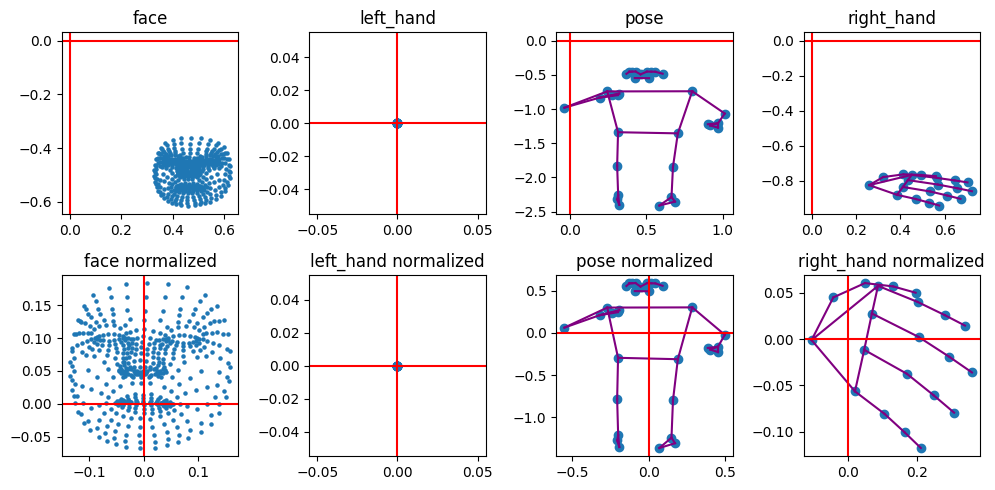

In [53]:
f, l, p, r = split_tensor(test_full)
f, l, p, r = normalize_center(f, l, p, r)
test_normalize = tf.concat([f, l, p, r], axis=-2)
plot_two_tensors(test_full, test_normalize, frame=0, label='normalized', show_origin=True)

## Standardizing Frame Count

This method attempts to increase low-frame-count data and decrease high-frame-count data. It achieves this through a combination of reflection, repetition, and moving averages.

**Note: this is not used in the final submission**

In [54]:
# The goal of this function is to pad low-frame data and trim high-frame data slightly (every other frame)
def standardize_frames(tensor, frames=DESIRED_FRAMES, trim=False):
    # Create moving average for timeseries tensor
    # Inspiration: https://www.kaggle.com/code/dilipkumar2k6/tensorflow-timeseries-moving-average
    def tensor_moving_average(t, window_size):
        # Repeat
        axis = -3
        repeats = window_size // tf.shape(t)[axis] + 1 # This repeats vector will always be 1 if window_size is < timesteps
        t = tf.repeat(t, repeats, axis=axis)
        timesteps = tf.shape(t)[axis]

        # Moving average
        cumsum = tf.cumsum(t, axis=axis)
        uppersum = cumsum[..., window_size:, :, :]
        lowersum = cumsum[..., :-window_size, :, :]
        ma = (uppersum - lowersum) / window_size
        return ma

    # Shape (frames, rows, channels)
    timesteps = tf.shape(tensor)[-3]
    
    if timesteps < frames:
        # Pad frames
        # Padding size
        pad = frames - timesteps
        pad = (pad if pad < timesteps else timesteps - 1)
        
        # Pad tensor
        tensor = tf.pad(tensor, [[0, pad], [0, 0], [0, 0]], 'reflect')
        
    elif trim:
        # Trim frames
        # Let's capture the trimmed frames with a moving average
        tensor = tensor_moving_average(tensor, window_size=int(timesteps // frames + 3))
        
        # Setting steps for list of indices
        # i.e. reducing based on multiples of the desired frames, 1 for 40//40, 2 for 80//40, 3 for 120//40
        timesteps = tf.shape(tensor)[-3]
        steps = timesteps // frames
        steps = (1 if steps == 0 else steps)
        
        # List of indices
        collect = list(range(0, timesteps, steps))

        # Gather list of indices
        tensor = tf.gather(tensor, collect, axis=-3)

        # Recursive call if the tensor becomes smaller than desired frames
        tensor = standardize_frames(tensor, frames=frames, trim=False)
        
    return tensor

## Augmentation Testing

This helps us test the different factors used in augmentation to visualize what the effect will be. This step answers questions like: are we augmenting too heavily?

2/2 [==============================] - 0s 9ms/step


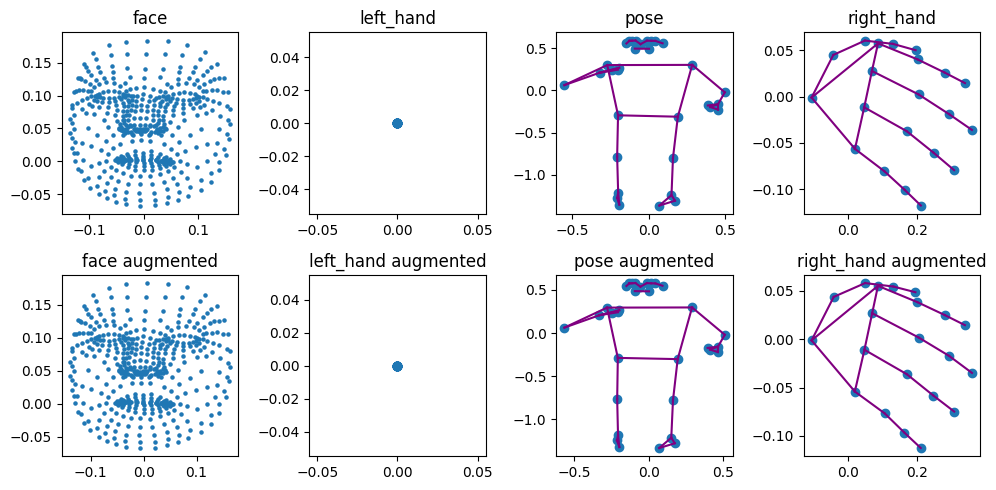

In [58]:
# Augmentation test
rate = 1

inp = tf.keras.layers.Input(shape=(ROWS_PER_FRAME, 3))
face, lhand, pose, rhand = split_tensor(inp)
# face, lhand, pose, rhand = RandomLR(rate=rate)([face, lhand, pose, rhand], training=True)
face, lhand, pose, rhand = RandomShift(rate=rate, factor=0.001)([face, lhand, pose, rhand], training=True)
face, lhand, pose, rhand = RandomScale(rate=rate, factor=0.05)([face, lhand, pose, rhand], training=True)
# face = RandomZero(rate=rate)(face, training=True)
# lhand = RandomZero(rate=rate)(lhand, training=True)
# pose = RandomZero(rate=rate)(pose, training=True)
# rhand = RandomZero(rate=rate)(rhand, training=True)
face, lhand, pose, rhand = layers.Lambda(
    lambda t: normalize_center(t[0], t[1], t[2], t[3]), name = 'normalize_center')([face, lhand, pose, rhand])
out = layers.Concatenate(axis=-2)([face, lhand, pose, rhand])
model = Model(inp, out)

test = model.predict(test_full)

plot_two_tensors(test_normalize, test, frame=0, label='augmented')

## Dominant Hand Standardization (LR Standardization)

This method takes the most frequently appearing hand and makes it the dominant hand. If it is the left hand, the data is unaffected. If it is the right hand, it is flipped laterally and turned into the left hand. We find the dominant hand by comparing the sum of the features in all frames.

**Note: this method is sort of hand-wavy, and assumes the dominant hand is always the larger sum. This might be a major assumption. Yet it works well.**

In [59]:
def standardize_lr(face, lhand, pose, rhand):
    # Input shape (batch, timesteps, rows, channels)
    
    # Invert function
    def flip_lr(face, lhand, pose, rhand, flip):
        # Inputs in appropriate order:
        # face = inputs[0]
        # lhand = inputs[1]
        # pose = inputs[2]
        # rhand = inputs[3]

        def invert_function(t):
            # Variables
            x = t[..., :1] # x axis
            yz = t[..., 1:] # y and z axes

            # Recombine flipped x with y and z
            t = tf.concat([
                tf.multiply(x, -1), # flip
                yz
            ], axis=-1) 

            return t

        # Invert face, lhand, pose, and rhand horizontally
        face = tf.where(flip, invert_function(face), face)
        lhand = tf.where(flip, invert_function(lhand), lhand)
        pose = tf.where(flip, invert_function(pose), pose)
        rhand = tf.where(flip, invert_function(rhand), rhand)

        # Switch lhand with rhand
        return [face, rhand, pose, lhand]
    
    # Sum left hand for all rows
    l_sum = tf.reduce_sum(lhand, axis=(-3, -2, -1), keepdims=True)
    # Sum right hand for all rows
    r_sum = tf.reduce_sum(rhand, axis=(-3, -2, -1), keepdims=True)
    # if right is greater than left, flip
    face, lhand, pose, rhand = flip_lr(face, lhand, pose, rhand, tf.greater(r_sum, l_sum))
    
    return [face, lhand, pose, rhand]

In [98]:
f, l, p, r = split_tensor(test_full)
print(tf.reduce_sum(r, axis=(-3, -2, -1)).numpy())
f, l, p, r = standardize_lr(f, l, p, r)
print(tf.reduce_sum(r, axis=(-3, -2, -1)).numpy())

600.7379275114343
0.0


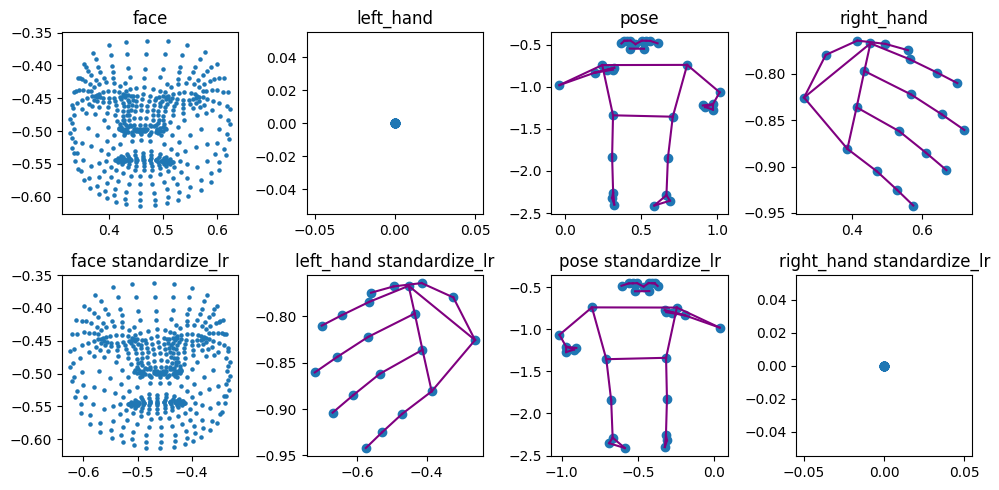

In [101]:
# Example of left/right standardization
test_standardize_lr = tf.concat([f, l, p, r], axis=-2)
plot_two_tensors(test_full, test_standardize_lr, frame=0, label='standardize_lr')

# Create TFRecords

We converted our parquet files into a `TFRecords` dataset in order to speed up training while keeping our preprocessing options open. `TFRecords` allow you to use ragged tensors (tensors of different shapes) and yet load them as non-ragged tensors through padding. This is performed by the `TFRecords` function `bucket_by_sequence_length()`.

In [65]:
# Convert paths dataframe to a tfrecord file (inplace)
def paths_to_tfrecord(df, output_file, test=False):
    length = len(df)
    print('Data Length: {}'.format(length))
    with tf.io.TFRecordWriter(output_file) as writer:
        for i, row in enumerate(df.T):
            path = os.path.join(FOLDER_PATH, df.loc[row].path)
            
            # Data
            data = load_relevant_data_subset(path)
            
            if not test:
                data = tf.where(tf.math.is_nan(data), tf.zeros_like(data), data)
#                 data = filter_bad_frames(data, remove=True)
#                 if data.shape[0] == 0:
#                     continue
#                 data = standardize_frames(data, trim=True)
                data = data.numpy().flatten().tolist()
            else:
                data = data.flatten().tolist()
            
            # Label
            label_index = signs[df.loc[row].sign]
            label = np.zeros(250).astype(int)
            label[label_index] = 1
            
            # Define dtypes
            feature = {
#                 'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[data])),
                'data': tf.train.Feature(float_list=tf.train.FloatList(value=data)),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=label))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            serialized = example.SerializeToString()
            writer.write(serialized)

            progressBar(i + 1, length)
        print('\n')
            
if CREATE_TFRECORD:
#     paths_to_tfrecord(csv, TFRECORD_PATH)
    paths_to_tfrecord(train_csv, TFRECORD_PATH_TRAIN, test=True)
    paths_to_tfrecord(test_csv, TFRECORD_PATH_TEST, test=True)

# Loading Data

Here we make a decision on what `bucket_boundaries` to use. Basically, the function will create buckets containing data of associated timesteps. Batches are then created out of these buckets. If `bucket_boundaries = [0]` the function will create automatic buckets based on whatever data it sees first - the padding will be decided based on the largest timestep within the batch.

We have opted to use auto-padding so as to promote proper batch distribution. Since some signs have a higher average frames-per-sign, creating timestep specific batches may prevent some signs from being trained together.

In [66]:
def _parse_data_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary
    example = tf.io.parse_single_example(example_proto, feature_description)
    data = tf.sparse.to_dense(example['data'])
    data = tf.reshape(data, [-1, ROWS_PER_FRAME, 3])
#     data = data[:DESIRED_FRAMES, ...]
#     label = tf.reshape(example['label'], [250,])
    
    return [data, example['label']]


def parse_dataset(raw_dataset):
    parsed_dataset = raw_dataset.map(_parse_data_function)
    # parsed_dataset = parsed_dataset.batch(BATCH_SIZE)
    parsed_dataset = parsed_dataset.bucket_by_sequence_length(
        element_length_func = lambda x, y: tf.shape(x)[0],
        bucket_boundaries = bucket_boundaries,
        bucket_batch_sizes = [BATCH_SIZE] * (len(bucket_boundaries) + 1),
    #     pad_to_bucket_boundary = True,
    #     no_padding = True,
    #     drop_remainder = True
    )
    # parsed_dataset = parsed_dataset.apply(tf.data.experimental.dense_to_ragged_batch(BATCH_SIZE))
    return parsed_dataset

# bucket_boundaries = list(range(MAX_TIMESTEPS + 2)) # No padding from 0 to 537
# bucket_boundaries = list(range(50 + 1))
# bucket_boundaries = [5 * i for i in range(111)] # Light padding increments of 5 from 0 to 550
# bucket_boundaries = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 150, 200, 300, MAX_TIMESTEPS + 2] # Heavy padding
# bucket_boundaries = [10, 30, 40, 50, 75, 100, 150] # Heavy padding 2
# bucket_boundaries = [5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100] # Heavy padding 3
# bucket_boundaries = [40, 50, 70, 100] # Heavy padding 4
bucket_boundaries = [0] # Auto Padding
# bucket_boundaries = [MAX_TIMESTEPS + 2] # All for one
# bucket_boundaries = [DESIRED_FRAMES + 1]
# bucket_boundaries = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 50]

# Create dictionary describing features
feature_description = {
#     'data': tf.io.FixedLenFeature([], tf.string),
    'data': tf.io.VarLenFeature(tf.float32),
    'label': tf.io.FixedLenFeature([250], tf.int64)
}

raw_dataset_train = tf.data.TFRecordDataset(TFRECORD_PATH_TRAIN)
raw_dataset_test = tf.data.TFRecordDataset(TFRECORD_PATH_TEST)

parsed_dataset_train = parse_dataset(raw_dataset_train)
parsed_dataset_test = parse_dataset(raw_dataset_test)

In [67]:
# Shuffle data
parsed_dataset_train = parsed_dataset_train.shuffle(buffer_size=3*BATCH_SIZE, reshuffle_each_iteration=False)
parsed_dataset_test = parsed_dataset_test.shuffle(buffer_size=3*BATCH_SIZE, reshuffle_each_iteration=False)

In [68]:
# Creating train, val, test sets
take = int(VAL_SIZE / BATCH_SIZE)

if CONCAT_DATASET:
    parsed_dataset_train = parsed_dataset_train.concatenate(parsed_dataset_test)
    parsed_dataset_train.shuffle(buffer_size=3*BATCH_SIZE, reshuffle_each_iteration=False)
    
val_data = parsed_dataset_train.take(take)
train_data = parsed_dataset_train.skip(take)
test_data = parsed_dataset_test

In [69]:
# Example batch stats
for x, y in train_data.take(1):
    print('Example batch shape: {}'.format(x.shape))
    print('Number of zeros:     {}'.format(tf.reduce_sum(tf.cast(tf.equal(x, 0), dtype=tf.int32)).numpy()))
    print('Number of nans:      {}'.format(tf.reduce_sum(tf.cast(tf.math.is_nan(x), dtype=tf.int32)).numpy()))
    print('Number of finites:   {}'.format(tf.reduce_sum(tf.cast(tf.math.is_finite(x), dtype=tf.int32)).numpy()))

Example batch shape: (32, 119, 543, 3)
Number of zeros:     4554684
Number of nans:      95841
Number of finites:   6107391


# Model

In [70]:
def positional_encoding(t):
    # Custom positional encoding
    # input tensor (batch, time, features)

    # create a position tensor from 0 to len(time) 
    # pos shape = (time, features)
    pos = tf.range(tf.shape(t)[-2], dtype=tf.float32)
    pos = tf.expand_dims(pos, 0)
    pos = tf.repeat(pos, tf.shape(t)[-1], axis=0)        
    pos = tf.transpose(pos)

    # incorporate feature number (cannot contain zero)
    # i shape = (time, features)
    i = tf.range(1, tf.shape(t)[-1] + 1, dtype=tf.float32)
    i = tf.expand_dims(i, 0)
    i = tf.repeat(i, tf.shape(t)[-2], axis=0)

    # total number of features
    d = tf.shape(t)[-1]
    d = tf.reshape(d, [-1])
    d = tf.cast(d, dtype=tf.float32)
    
    # trainable sin weights like in BERT (source: https://openreview.net/pdf?id=onxoVA9FxMw)
    w = layers.Dense(t.shape[-1], activation='relu')(t)

    # trainable encoding
    # positional_encoding shape = (batch, time, features)
    positional_encoding = (pos / tf.pow(10000.0, (2.0 * i / d))) # shape = (time, features)
    positional_encoding = tf.expand_dims(positional_encoding, 0)
    positional_encoding = tf.repeat(positional_encoding, tf.shape(t)[0], axis=0)
    positional_encoding = tf.where(tf.equal(i // 2, 0),
                                    tf.math.cos(w*positional_encoding),
                                    tf.math.sin(w*positional_encoding))
    
    # finally, add to original tensor
    return t + positional_encoding

    
def embedding_layer(t, activation, regularization):
    # Custom embedding layer that embeds all channels together
    t = layers.Reshape((-1, 3*t.shape[-2]))(t)
    t = layers.Dense(units=t.shape[-1], activation=activation, kernel_regularizer=regularization)(t)
    return t

def multi_attention(l, num_heads, dense_units, activation, regularization, dropout, pool_output=True):
    # Custom MultiAttention Block with per-head positional encoding
    # Attention Heads
    attention = []
    l = layers.LayerNormalization()(l)
    for i in range(num_heads):
        # Per head dropout and positional encoding
        d = layers.Dropout(dropout)(l)
        d = layers.SpatialDropout1D(dropout)(d) # Temporal dropout
        d = positional_encoding(d)

        # Query, Value, and Key
        q = layers.Dense(units=dense_units, activation=activation, kernel_regularizer=regularization)(d)
        v = layers.Dense(units=dense_units, activation=activation, kernel_regularizer=regularization)(d)

        # Attention and normalization
        a = layers.Attention(use_scale=True)([q, v])
        a = layers.LayerNormalization()(a)

        # Multi-hop attention source: https://aclanthology.org/P19-2030.pdf
        # Source 2: https://medium.com/@asmitasinha/pay-attention-to-mlps-bb5124e3db75
#             a = mlp(a, dense_units)

        if pool_output:
            # we need something to handle the time dimension better than just pooling
            a = layers.GlobalAveragePooling1D()(a)
#                 a = layers.GlobalMaxPooling1D()(a)
        attention.append(a) 

    if num_heads == 1:
        return attention[0]
    return layers.Concatenate(axis=-1)(attention)

def mlp(t, dense_units, activation, regularization):
    # Multi-Layer Perceptron
    # Hidden layers
    h = layers.Dense(units=dense_units, activation=activation, kernel_regularizer=regularization)(t)
    h = layers.Dense(units=dense_units, activation=activation, kernel_regularizer=regularization)(h)

    # Recombine and evaluate
    t = layers.Concatenate(axis=-1)([t, h])
    t = layers.Dense(units=vocab_size, activation='softmax', kernel_regularizer=regularization)(t)

    return t

In [72]:
def get_model(training):
    # Building the tensorflow model
    tf.keras.backend.clear_session() # Useful in testing

    # Optimizer
    lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.00050,
        decay_steps=10000,
        decay_rate=0.95)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_decay)

    # Variables
    channels = 3
    vocab_size = len(signs)
    activation = 'relu'
    regularization = regularizers.l2(0.00001)
    dropout = 0.20

    # Inputs
    inputs = tf.keras.Input(shape=(None, ROWS_PER_FRAME, channels))
    
    # Filter Nans (nans to zeros)
    x = layers.Lambda(lambda t: tf.where(tf.math.is_nan(t), tf.zeros_like(t), t), name='filter_nans')(inputs)
    
    # Filter bad frames
    x = layers.Lambda(lambda t: filter_bad_frames(t, remove=False, batch=True), name='filter_bad_frames')(x)

    # Split input into landmark features [0, 468, 489, 522]
    face, lhand, pose, rhand = split_tensor(x)
    
    # Standardize left and right signers (right to left)
    face, lhand, pose, rhand = layers.Lambda(
        lambda t: standardize_lr(t[0], t[1], t[2], t[3]), name = 'standardize_lr')([face, lhand, pose, rhand])
    
    # Mask zeros after standardization
    face = layers.Masking(mask_value=0.)(face)
    lhand = layers.Masking(mask_value=0.)(lhand)
    pose = layers.Masking(mask_value=0.)(pose)
    rhand = layers.Masking(mask_value=0.)(rhand)
    
    # Augmentation
    if training: # only implement these custom layers in training
        rate = 0.3
        face, lhand, pose, rhand = RandomShift(rate=rate, factor=0.000001)([face, lhand, pose, rhand]) # Independent translation that doesn't affect zeros
        face, lhand, pose, rhand = RandomScale(rate=rate, factor=0.0001)([face, lhand, pose, rhand]) # Coordinate Scaling
    
    # Normalize and Center
    face, lhand, pose, rhand = layers.Lambda(
        lambda t: normalize_center(t[0], t[1], t[2], t[3]), name = 'normalize_center')([face, lhand, pose, rhand])
    
    # Feature reduction
    face = tf.gather(face, lip_rows, axis=-2) # Lips only
    pose_arm_l = tf.gather(pose, arm_l, axis=-2)
    pose_arm_r = tf.gather(pose, arm_r, axis=-2)
    pose_face = tf.gather(pose, face_p, axis=-2)
    
    # Feature engineering
    # Major directions
    head_direction = direction(tf.gather(pose, [9], axis=-2), tf.gather(pose, [10], axis=-2))
    hand_direction = direction(tf.gather(lhand, [0], axis=-2), tf.gather(lhand, [5], axis=-2))
    # Arm Angles
    elbow_angle = three_point_angle(pose, 11, 13, 15)
    armpit_angle = three_point_angle(pose, 23, 11, 13)
    # Finger angle (how much it curls)
    index_angle = three_point_angle(lhand, 5, 6, 8)
    middle_angle = three_point_angle(lhand, 9, 10, 12)
    ring_angle = three_point_angle(lhand, 13, 14, 16)
    pinky_angle = three_point_angle(lhand, 17, 18, 20)
    thumb_angle = three_point_angle(lhand, 2, 3, 4)
    # Angle made by the knuckles of pinky, ring, and middle finger
    knuckle_angles = three_point_angle(lhand, 10, 14, 18)
    # Distance between thumb tip and other finger tips
    thumb_pinky_distance = tf.gather(lhand, [4], axis=-2) - tf.gather(lhand, [20], axis=-2)
    thumb_ring_distance = tf.gather(lhand, [4], axis=-2) - tf.gather(lhand, [16], axis=-2)
    thumb_middle_distance = tf.gather(lhand, [4], axis=-2) - tf.gather(lhand, [12], axis=-2)
    thumb_index_distance = tf.gather(lhand, [4], axis=-2) - tf.gather(lhand, [8], axis=-2)
    # Distance between thumb tip and other finger tips
    ring_pinky_distance = tf.gather(lhand, [18], axis=-2) - tf.gather(lhand, [14], axis=-2)
    middle_ring_distance = tf.gather(lhand, [14], axis=-2) - tf.gather(lhand, [10], axis=-2)
    index_middle_distance = tf.gather(lhand, [10], axis=-2) - tf.gather(lhand, [6], axis=-2)
    index_thumb_distance = tf.gather(lhand, [4], axis=-2) - tf.gather(lhand, [6], axis=-2)
    # Finger tip directions
    thumb_direction = direction(tf.gather(lhand, [3], axis=-2), tf.gather(lhand, [4], axis=-2))
    index_direction = direction(tf.gather(lhand, [7], axis=-2), tf.gather(lhand, [8], axis=-2))
    middle_direction = direction(tf.gather(lhand, [11], axis=-2), tf.gather(lhand, [12], axis=-2))
    ring_direction = direction(tf.gather(lhand, [15], axis=-2), tf.gather(lhand, [16], axis=-2))
    pinky_direction = direction(tf.gather(lhand, [19], axis=-2), tf.gather(lhand, [20], axis=-2))
    # Finger tip directions
    larm_direction = direction(tf.gather(pose, [13], axis=-2), tf.gather(pose, [15], axis=-2))
    rarm_direction = direction(tf.gather(pose, [14], axis=-2), tf.gather(pose, [16], axis=-2))
        
    # Embedding all features seperately
    embedding = []
    for t in [
                face, pose,
                lhand, rhand,
                head_direction, hand_direction,
                elbow_angle, armpit_angle,
                index_angle, middle_angle, ring_angle, pinky_angle, thumb_angle,
                knuckle_angles,
                thumb_pinky_distance, thumb_ring_distance, thumb_middle_distance, thumb_index_distance,
                ring_pinky_distance, middle_ring_distance, index_middle_distance, index_thumb_distance,
                thumb_direction, index_direction, middle_direction, ring_direction, pinky_direction,
                larm_direction, rarm_direction,
             ]:
        embedding.append(embedding_layer(t, activation, regularization))
    
    # Recombine
    x = layers.Concatenate(axis=-1)(embedding)
    
    # Custom Multi-Attention Block
    x = multi_attention(
        x, 
        num_heads=8, 
        dense_units=64, 
        activation=activation, 
        regularization=regularization, 
        dropout=0.30, 
        pool_output=True)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization()(x)
    
    # Output
    predictions = layers.Dense(vocab_size, activation='softmax', kernel_regularizer=regularization)(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01), # Source: https://www.kaggle.com/competitions/asl-signs/discussion/391265
                  metrics=['top_k_categorical_accuracy', 'accuracy']
                 )
    
    return model

In [1]:
model = get_model(training=True)
# model.summary()

In [75]:
# Preset weights
if SET_WEIGHTS:
    # Get indeces to ignore
    indices = [
        model.layers.index(model.get_layer(name='random_shift')),
        model.layers.index(model.get_layer(name='random_scale')),
    ]
    
    # Get model
    weights_model = tf.keras.models.load_model(MODEL_PATH_WEIGHTS)
    
    # Get weights
    weights = []
    for i in range(len(weights_model.layers)):
        weights.append(weights_model.layers[i].get_weights())
        
    # Set weights
    for i in range(len(model.layers)):
        if i not in indices:
            model.layers[i].set_weights(weights[0])
            weights.pop(0)

In [76]:
# tf.keras.utils.plot_model(model)

In [77]:
# Create class_weights using inverse sign frequency
class_weight = (csv['sign'].value_counts().max() / csv['sign'].value_counts()).sort_index().reset_index(drop=True)

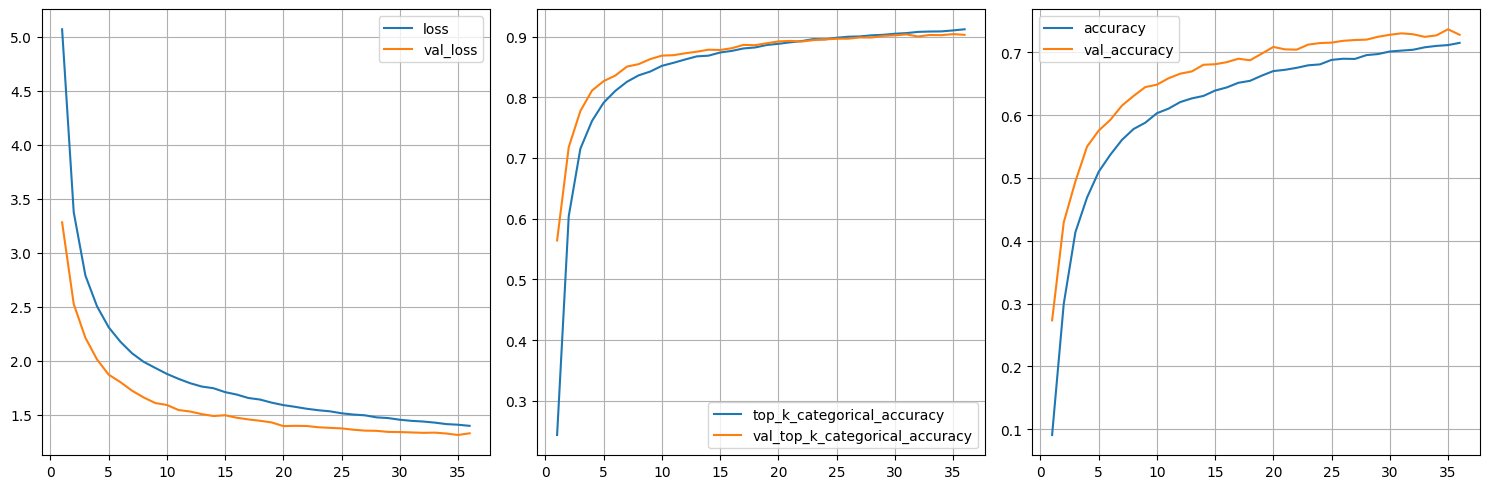


Epoch 36: val_accuracy did not improve from 0.73667
2582/2582 [==============================] - 355s 135ms/step - loss: 1.3982 - top_k_categorical_accuracy: 0.9119 - accuracy: 0.7150 - val_loss: 1.3293 - val_top_k_categorical_accuracy: 0.9028 - val_accuracy: 0.7279
Learning rate for epoch 37: 0.00031
Epoch 37/100


In [78]:
# Train the model
if TRAIN:
    # Add a checkpoint callback to store the checkpoint that has the highest validation accuracy
    checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.best.hdf5',
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
    
    fitModel = model.fit( train_data
    #                     , train_labels
                        , epochs=100
                        , batch_size=BATCH_SIZE
                        , shuffle=True
    #                     , validation_split=0.3
                        , validation_data = val_data
                        , verbose=1
                        , callbacks=[PlotLearning(), LearningRateLogger(), checkpoint, earlystopping]
                        , class_weight=class_weight.to_dict()
    #                     , steps_per_epoch=int(len(csv)/BATCH_SIZE) # Messes with training if not accurate, just wait an epoch
                        )

In [79]:
# Remove custom layers
# Easier TFLite conversion for inferencing
if TRAIN:
    # Get indeces to remove
    indices = [
        model.layers.index(model.get_layer(name='random_shift')),
        model.layers.index(model.get_layer(name='random_scale')),
    ]
    
    # Get weights
    weights = []
    for i in range(len(model.layers)):
        if i not in indices:
            weights.append(model.layers[i].get_weights())
    
    # Create model
    new_model = get_model(training=False)
    
    # Set weights
    for i in range(len(new_model.layers)):
        new_model.layers[i].set_weights(weights[i])

In [80]:
if TRAIN:
    new_model.save(MODEL_PATH_TRAIN)

In [81]:
if TRAIN:
    print("Evaluate on test data")
    results = new_model.evaluate(test_data)

Evaluate on test data
154/154 [==============================] - 21s 88ms/step - loss: 1.4848 - top_k_categorical_accuracy: 0.9102 - accuracy: 0.6810


In [82]:
if CONVERT and not TRAIN:
    new_model = tf.keras.models.load_model(MODEL_PATH_TRAIN)

In [83]:
# tf.keras.utils.plot_model(new_model)

# Analysis

Analysis is performed on a test set consisting of a participant that has been entirely excluded from the training and validation sets. A test set of a single participant isn't enough, but it's a start to better understand how our model generalizes. Using these results, we can see which words our model is struggling to identify. We can also tell which words our model is confusing with each other. This helps us iterate and come up with new ways to spoon-feed our model refined features so that it performs better.

In [84]:
# Returns predictions as well as labels
def predict_data(data):
    # Get predictions
    predictions = new_model.predict(data)
    pred = np.argmax(predictions, axis=1)
    
    # Get labels
    labels = []
    for _, y in data.unbatch():
        labels.append(np.argmax(y.numpy()))
    labels = np.asarray(labels)
    
    return pred, labels

In [85]:
test_pred, test_labels = predict_data(test_data)

154/154 [==============================] - 19s 79ms/step


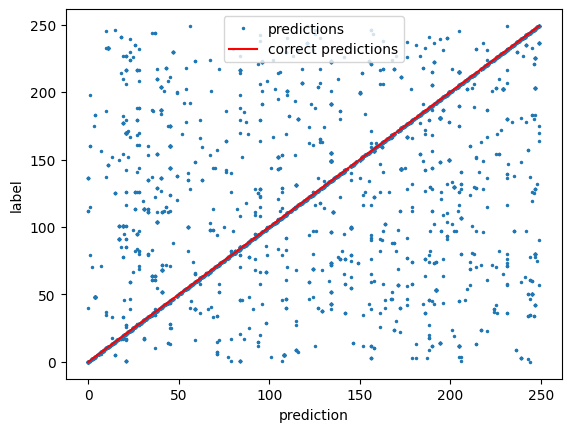

In [86]:
# Custom confusion matrix for 250 classes
plt.plot(test_pred, test_labels, label='predictions', marker='.', markersize=3, linestyle='')
plt.xlabel('prediction')
plt.ylabel('label')
plt.plot(list(range(250)), list(range(250)), color='red', label='correct predictions')
plt.legend()
# plt.axhline(149)
plt.show()

In [87]:
# Find out what the 5 worst prediction classes are
correct = []
incorrect = []
incorrect_predictions = [[] for i in range(250)]
for i, y in enumerate(test_labels):
    if y == test_pred[i]:
        correct.append(y) 
    else:
        incorrect.append(y)
        incorrect_predictions[y].append(test_pred[i])
correct = np.asarray(correct)
incorrect = np.asarray(incorrect)

bar_cor, height_cor = np.unique(correct, return_counts=True)
bar_inc, height_inc = np.unique(incorrect, return_counts=True)

df1 = pd.DataFrame(height_cor, index=bar_cor, columns=['number correct'])
df2 = pd.DataFrame(height_inc, index=bar_inc, columns=['number incorrect'])
df = df1.join(df2, how='outer').fillna(0).astype(int)
df['incorrect predictions'] = incorrect_predictions
df['incorrect predictions'] = df['incorrect predictions'].map(lambda x: [signs.index[s] for s in x])
df.index.name = 'sign index'
df = df.set_index(df.index.map(lambda x: signs.index[x]))
df['class accuracy'] = (df['number correct'] / (df['number correct'] + df['number incorrect'])).round(2)
df.sort_values('class accuracy', ascending=False).tail(50)

,number correct,number incorrect,incorrect predictions,class accuracy
sign index,,,,
flag,8,11,"[fish, fish, beside, fish, bedroom, fish, besi...",0.42
chair,8,11,"[jump, dance, pizza, haveto, haveto, pizza, ow...",0.42
bed,7,10,"[brown, fine, flower, bedroom, beside, brown, ...",0.41
puppy,7,10,"[drawer, boat, fish, beside, give, boat, boat,...",0.41
not,8,12,"[any, same, nuts, nuts, nuts, nuts, nuts, nuts...",0.40
noisy,8,12,"[tree, rain, rain, cat, tree, cat, cat, cat, b...",0.40
all,8,12,"[ride, not, who, quiet, who, who, not, who, no...",0.40
pen,8,12,"[potty, potty, potty, pencil, potty, bird, tim...",0.40
say,8,12,"[glasswindow, lips, glasswindow, lips, lips, l...",0.40


In [88]:
csv['sign'].value_counts().sort_values(ascending=False).loc['mouth']

391

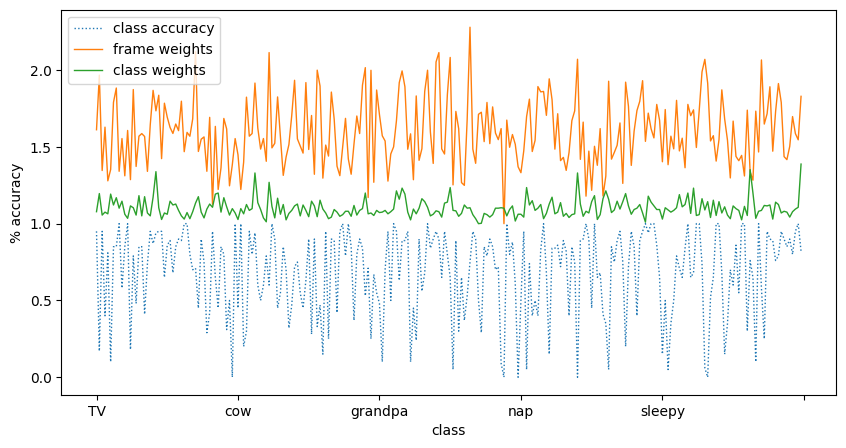

In [89]:
# Question: is there a correlation between class accuracy, class weights or average number of frames per class? 
# That would indicate a bias
# What we're looking for: smoother accuracy plot with less outliers
fig = plt.figure(figsize=(10,5))

# Class accuracy
df['class accuracy'].plot(linestyle=':', linewidth=1)
# Frame weights
(frames_df['frame_average'].max() / frames_df['frame_average']).plot(linewidth=1) # df['class accuracy'].reset_index(drop=True) * 
# Class weights
df['class weights'] = (csv['sign'].value_counts().max() / csv['sign'].value_counts()).sort_index()
(df['class weights']).plot(linewidth=1) #df['class accuracy'] * 

plt.xlabel('class')
plt.ylabel('% accuracy')
plt.legend(['class accuracy', 'frame weights', 'class weights'])

In [90]:
# # Visualize specific labels
# study_data = []
# for x, y in test_data.unbatch():
#     label = np.argmax(y.numpy())
#     if label == 40:
#         study_data.append(x.numpy())

In [91]:
# for x in study_data:
#     plot_all_tensor(x, frame = 20)

In [92]:
# Standard TF accuracy metric to see if we converted properly
acc = df['number correct'].sum() / len(test_labels) * 100
print('Accuracy: {}%'.format(acc))

Accuracy: 68.10204081632652%


# Convert to TFLite

In [93]:
# Create the TFLite model using the appropriate GISLR format
def get_inference_model(model = new_model): # Inspired by https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language#Submit-Model
    # Inputs
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME, 3), name='inputs')
    
    # Model
    x = tf.expand_dims(inputs, 0) # Expand to batch size of 1
    x = model(x)
    
    # Outputs
    predictions = layers.Activation('linear', name='outputs')(x)
    
    # Build model
    inference_model = tf.keras.Model(inputs=inputs, outputs=predictions)
    inference_model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
    
    return inference_model

if CONVERT:
    inference_model = get_inference_model()
    inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 543, 3)]          0         
                                                                 
 tf.expand_dims_24 (TFOpLamb  (1, None, 543, 3)        0         
 da)                                                             
                                                                 
 model (Functional)          (None, 250)               2009594   
                                                                 
 outputs (Activation)        (1, 250)                  0         
                                                                 
Total params: 2,009,594
Trainable params: 2,009,594
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Convert to TFLite with optimization
if CONVERT:
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
    
    if OPTIMIZE:
        # Convert to TF Lite with quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Enabling ragged tensors (source: https://github.com/tensorflow/tensorflow/issues/50942#issuecomment-886203381 )
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
#     converter._experimental_lower_tensor_list_ops = True

    tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\AbEl-\AppData\Local\Temp\tmp24qs8vuz\assets


In [95]:
if CONVERT:
    # Save the model
    with open(MODEL_PATH, 'wb') as f:
        f.write(tflite_model)
    !zip submission.zip $MODEL_PATH

updating: model.tflite (164 bytes security) (deflated 31%)


In [96]:
# Inference using saved TFLite model
interpreter = tf.lite.Interpreter(MODEL_PATH)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

tfl_pred = []
tfl_label = []
for x, y in test_data.unbatch():
    output = prediction_fn(inputs=x)
    sign = np.argmax(output["outputs"])
    tfl_pred.append(np.argmax(y))
    tfl_label.append(sign)

In [97]:
tfl_correct = np.asarray(tfl_pred) == np.asarray(tfl_label)
tfl_correct = tfl_correct.astype(int).sum() / len(tfl_label) * 100
print('Accuracy: {}%'.format(acc))

Accuracy: 68.10204081632652%
